## Kickstarter Projectsのデータセットを用いて、クラウドファンディングが成功するか予測するモデルを構築する（Day3）

## 本notebookの内容

**下準備**  
・説明変数periodの追加（前回同様）  
・目的変数stateをダミー変数へ変換（前回同様）  
・不要な説明変数削除（前回同様）    
・カテゴリ変数を、get_dummiesでone-hotベクトルとする（追加）  
・外れ値確認（前回同様）  

**特徴量選択（Day3）**  
・埋め込み法による特徴量選択(削減）（追加）  

**モデル構築**  
①ホールドアウト法（やり直し）  
　・ホールドアウト法に誤りがあったためやり直し（テストデータに対してclf.fitを呼び出していた）  
②交差検証法（やり直し）  
　・同様に誤りがあったため、やり直し  
③SVM（追加）  
　・前回断念したSVMについて、データを一部サンプリングして少量にしてから試す  
　・グリッドサーチによるパラメータ最適化  
④ランダムフォレスト（追加）  
⑤アダブースト&決定木（追加）  
⑥ニューラルネットワーク（追加）  

**まとめ**  
　・各モデルでの予測精度まとめ  
　・今後の課題

## 下準備

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier,LassoCV
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
import pydotplus
import graphviz
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from io import StringIO
from tensorflow import keras  
import tensorflow as tf
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from tensorflow.keras.utils import to_categorical

In [2]:
#csvファイルの読み込み
df = pd.read_csv('../task/ks-projects-201801.csv')
#最初の5行を表示
display(df.head())
#
df.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


**説明変数の追加**  

deadlineからlaunchを引いた期間(period)を定義する

In [3]:
#datetime型に変換（launchedは時刻部分を削除）
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(pd.to_datetime(df['launched']).dt.date) #.dt.dateで日付まで表記（時刻削除）

#差を期間とする
df['period'] = (df['deadline'] - df['launched']).dt.days

**目的変数をダミー変数へ変換**  

・failed,successful,その他の個数を確認し、その他を削除する  
・successful=1,failed=0とする

In [4]:
# 現状確認
df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [5]:
#failed,successful以外を削除
df = df.query('state == ["failed","successful"]')
#successfulを1、failedを0に変換
df.replace({"successful":1,"failed":0}, inplace=True)
#削除できているか確認
df['state'].value_counts()

0    197719
1    133956
Name: state, dtype: int64

**計算負荷を減らすため説明変数を削除する**  

・関係のなさそうな変数：ID, name, deadline, launched    
・事前予測に使用できない変数：pledged, backers, usd pledged,　usd_pledged_real  
・単位の統一されていない変数：goal（usd_goal_realを採用）  
・似ていそうな変数：category,main_categoryを絞れるか確認  
・似ていそうな変数：currency,countryを絞れるか確認

In [6]:
# categoryのデータ数確認
df['category'].value_counts()

Product Design     18680
Documentary        14523
Music              12633
Tabletop Games     11744
Shorts             11394
                   ...  
Residencies           68
Letterpress           46
Chiptune              33
Literary Spaces       19
Taxidermy             10
Name: category, Length: 159, dtype: int64

In [7]:
# main_categoryのデータ数確認
df['main_category'].value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

→catogoryは細かすぎるため、計算量削減のためmain_categoryのみ採用

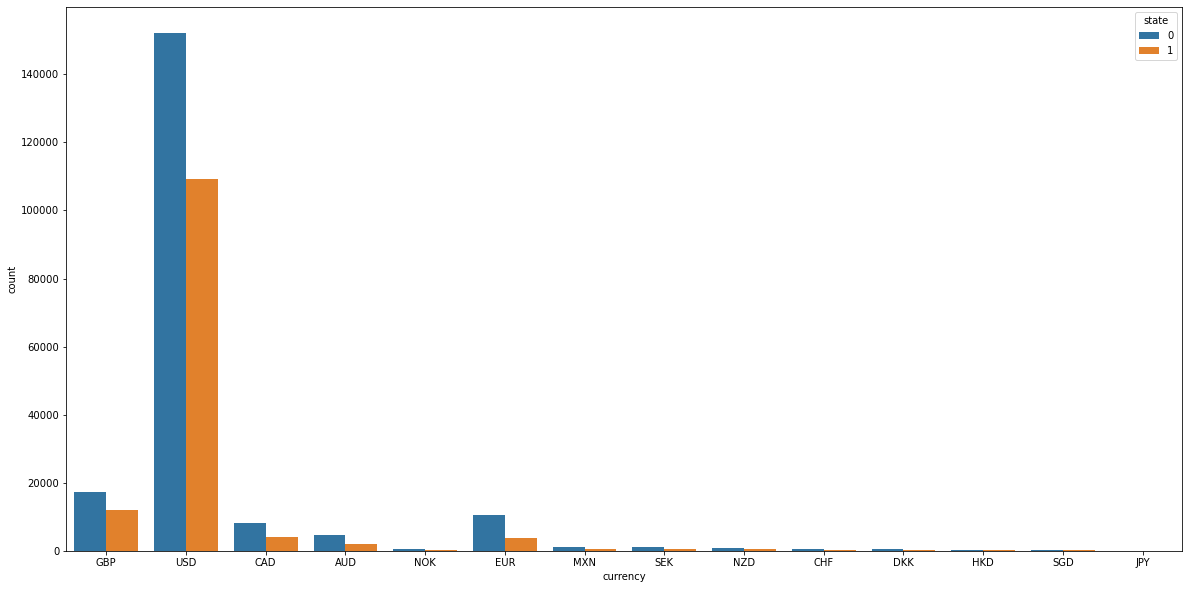

In [8]:
# 質的変数currencyとstateの関係性を可視化
plt.figure(figsize=(20, 10))
sns.countplot(x="currency", hue="state", data=df)

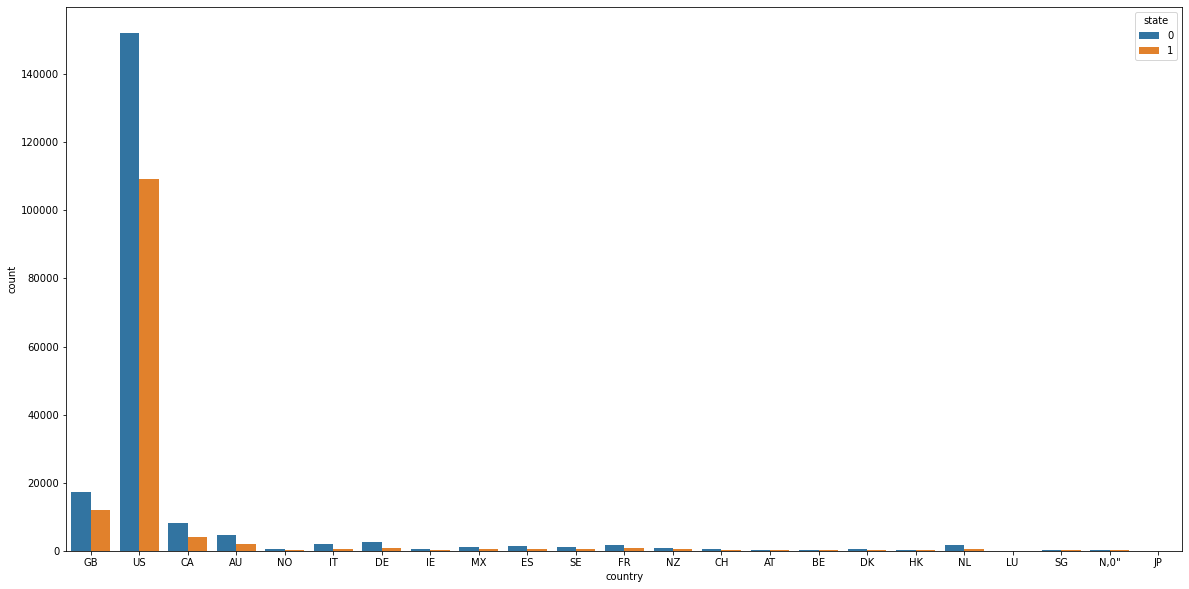

In [9]:
# 質的変数countryとstateの関係性を可視化
plt.figure(figsize=(20, 10))
sns.countplot(x="country", hue="state", data=df)

→currencyとcountryは傾向が似ているため、今後の計算量を削減するためcurrencyに絞る

In [10]:
# 上記で決定した不要な説明変数を削除
df = df[['main_category','currency','state','usd_goal_real','period']]
#削除できているか、period追加されているか確認
display(df.head())

,main_category,currency,state,usd_goal_real,period
0,Publishing,GBP,0,1533.95,59
1,Film & Video,USD,0,30000.00,60
2,Film & Video,USD,0,45000.00,45
3,Music,USD,0,5000.00,30
5,Food,USD,1,50000.00,35


**説明変数の前処理**  
・前回はカテゴリ変数を1,2,3・・・としていたが、今回はget_dummiesを使いone-hotベクトルとする

In [11]:
#カテゴリ変数をダミー変数に置換
df = pd.get_dummies(df)

#できているか確認
df.head()

,state,usd_goal_real,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,1533.95,59,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,30000.00,60,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,45000.00,45,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,5000.00,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,50000.00,35,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


(array([  6217.,  16787.,  34404., 194404.,  35162.,   8232.,  32765.,
           702.,    482.,   2520.]),
 array([ 1. , 10.1, 19.2, 28.3, 37.4, 46.5, 55.6, 64.7, 73.8, 82.9, 92. ]),
 <a list of 10 Patch objects>)

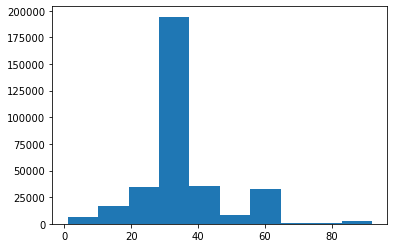

In [12]:
# periodの外れ値確認
plt.hist(df['period'])

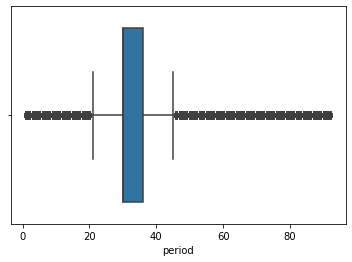

In [13]:
# 箱ひげ図
sns.boxplot(df['period'])

In [14]:
# 各period期間のデータ数確認
period_cut = pd.cut(df['period'],[0,10,20,30,40,50,60,70,80,90,100],right=True).value_counts()
print(period_cut)

(20, 30]     182367
(30, 40]      52565
(50, 60]      34980
(40, 50]      27875
(10, 20]      22847
(0, 10]        6217
(80, 90]       2148
(60, 70]       1617
(70, 80]        592
(90, 100]       467
Name: period, dtype: int64


外れ値にも見えた80付近の値も複数あるので、外れ値はなしと判断。

(array([3.31585e+05, 3.70000e+01, 7.00000e+00, 1.50000e+01, 5.00000e+00,
        2.00000e+00, 2.20000e+01, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([1.00000000e-02, 1.66361391e+07, 3.32722782e+07, 4.99084172e+07,
        6.65445563e+07, 8.31806954e+07, 9.98168344e+07, 1.16452974e+08,
        1.33089113e+08, 1.49725252e+08, 1.66361391e+08]),
 <a list of 10 Patch objects>)

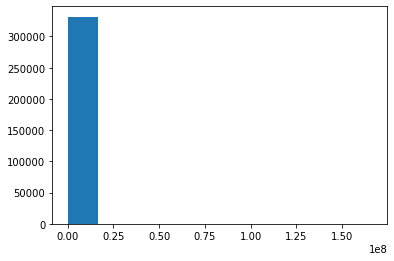

In [15]:
# usd_goal_realの外れ値確認
plt.hist(df['usd_goal_real'])

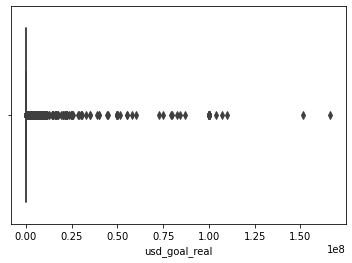

In [16]:
# 箱ひげ図
sns.boxplot(df['usd_goal_real'])

In [17]:
# 各データ区間でのデータ数確認
usd_cut = pd.cut(df['usd_goal_real'],[0,0.25*10**8,0.50*10**8,0.75*10**8,1*10**8,1.25*10**8,1.5*10**8,1.75*10**8],right=True).value_counts()
print(usd_cut)

(0.0, 25000000.0]             331615
(75000000.0, 100000000.0]         24
(25000000.0, 50000000.0]          24
(50000000.0, 75000000.0]           7
(100000000.0, 125000000.0]         3
(150000000.0, 175000000.0]         2
(125000000.0, 150000000.0]         0
Name: usd_goal_real, dtype: int64


→0.25×10^8以上のデータは複数あるが、それ以下のデータ数と桁が違うので、外れ値として削除する

(array([3.3126e+05, 1.5400e+02, 9.2000e+01, 2.3000e+01, 4.3000e+01,
        5.0000e+00, 9.0000e+00, 3.0000e+00, 1.4000e+01, 6.0000e+00]),
 array([1.00000000e-02, 2.46616728e+06, 4.93233454e+06, 7.39850181e+06,
        9.86466908e+06, 1.23308363e+07, 1.47970036e+07, 1.72631709e+07,
        1.97293381e+07, 2.21955054e+07, 2.46616727e+07]),
 <a list of 10 Patch objects>)

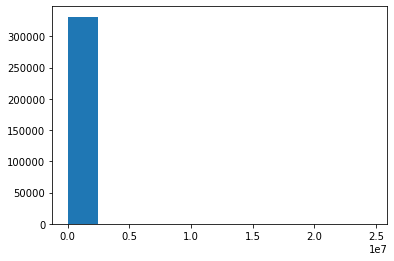

In [18]:
# 外れ値を削除し、ヒストグラム確認
df = df[df['usd_goal_real']<25000000]
plt.hist(df['usd_goal_real'])

(array([2.74698e+05, 2.80080e+04, 1.20140e+04, 4.39700e+03, 4.05600e+03,
        1.02200e+03, 1.48700e+03, 5.16000e+02, 8.85000e+02, 2.36000e+02]),
 array([1.00000000e-02, 2.49850090e+04, 4.99700080e+04, 7.49550070e+04,
        9.99400060e+04, 1.24925005e+05, 1.49910004e+05, 1.74895003e+05,
        1.99880002e+05, 2.24865001e+05, 2.49850000e+05]),
 <a list of 10 Patch objects>)

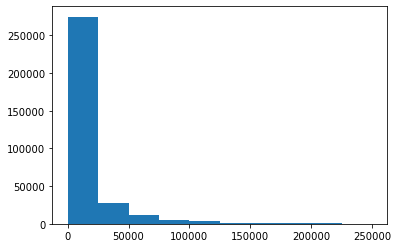

In [19]:
# 結果グラフの見た目が変わらないのでさらに2桁減らすこととする
df = df[df['usd_goal_real']<250000]
plt.hist(df['usd_goal_real'])

## 特徴量選択

**LASSOによる特徴量選択**  

・係数が多く計算に時間がかかると思われるため、係数が小さいものを削除したい。そこでLASSOによる特徴量選択を行う。  

In [20]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-2以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-2)

In [21]:
train_label = df["state"]
train_data = df.drop("state",axis=1)

y = train_label.values
X = train_data.values

# fitで特徴選択を実行
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(cv=10, normalize=True), threshold=0.01)

In [22]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False, False, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True])

In [23]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

Index(['usd_goal_real', 'period', 'main_category_Art',
       'main_category_Film & Video', 'currency_DKK', 'currency_GBP'],
      dtype='object')

In [24]:
# LASSOで得た各特徴の係数の値を確認する
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([2.79492696e-06, 3.85843180e-03, 0.00000000e+00, 1.42659832e-01,
       1.83947818e-01, 1.98315530e-01, 1.45903614e-02, 1.50064591e-01,
       6.08982827e-03, 1.29950748e-01, 2.18088039e-02, 1.77375563e-01,
       8.45686375e-02, 1.00407141e-01, 9.45451631e-02, 1.17750168e-01,
       1.91233994e-01, 6.95646711e-02, 5.03085160e-02, 3.43365342e-02,
       4.14351430e-03, 7.93154797e-02, 0.00000000e+00, 8.67004023e-02,
       7.34720931e-02, 1.27384869e-01, 9.53774927e-02, 3.79088099e-02,
       4.97020791e-02, 1.30922174e-02, 1.36589332e-02])

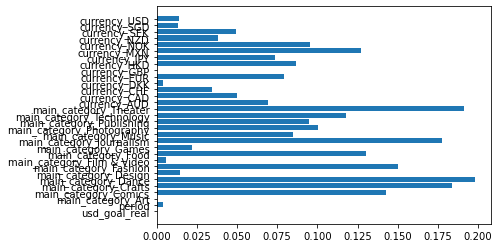

In [25]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

In [26]:
# 係数の小さかった'main_category_Art','main_category_Film & Video', 'currency_DKK', 'currency_GBP'を削除
# ただし、usd_goal_real,periodは重要そうなので、削除しない
df = df.drop(['main_category_Art','main_category_Film & Video', 'currency_DKK', 'currency_GBP'], axis=1)

display(df.head(10))
df.describe()

,state,usd_goal_real,period,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Food,main_category_Games,...,currency_CHF,currency_EUR,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,1533.95,59,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,30000.00,60,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,45000.00,45,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,5000.00,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,50000.00,35,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,1,1000.00,20,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
7,0,25000.00,45,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
10,0,2406.39,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1,12500.00,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12,0,5000.00,30,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,state,usd_goal_real,period,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Food,main_category_Games,...,currency_CHF,currency_EUR,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,327319.000000,327319.000000,327319.000000,327319.000000,327319.000000,327319.000000,327319.000000,327319.000000,327319.000000,327319.000000,...,327319.000000,327319.00000,327319.000000,327319.000000,327319.000000,327319.000000,327319.000000,327319.000000,327319.000000,327319.000000
mean,0.408589,14273.154165,33.871245,0.030124,0.023809,0.010879,0.076506,0.060128,0.066043,0.085556,...,0.001922,0.04301,0.001439,0.000070,0.004286,0.001748,0.003859,0.004540,0.001381,0.788790
std,0.491574,25559.836238,12.671519,0.170927,0.152453,0.103735,0.265807,0.237724,0.248357,0.279707,...,0.043795,0.20288,0.037906,0.008382,0.065330,0.041767,0.061998,0.067226,0.037135,0.408168
min,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2000.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,5000.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,15000.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,249850.000000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


 ## モデル構築

## ①ホールドアウト法

データを学習用とテスト用に分け、テスト用データで学習済みモデルの汎化誤差を評価する

In [27]:
# X, yの定義
y = df['state'].values
X = df.drop('state',axis=1).values

In [28]:
# 全データのうち、20%をテスト用データとする
test_size = 0.2
# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

学習用データ：fit_transform  
訓練データ：transform  
  
**訓練誤差を求める**

In [29]:
# 学習用データを標準化する
std_scaler = StandardScaler() 
# fit_transform関数で標準化した学習データX_train_stdを得る
X_train_std= std_scaler.fit_transform(X_train)

In [30]:
# モデルを作成、学習（ロジスティクス回帰）
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234,  tol=1e-3)
clf.fit(X_train_std, y_train)

# ラベルを予測
y_train_est = clf.predict(X_train_std)

print("学習データ（訓練誤差）")

# 正答率を計算
accuracy =  accuracy_score(y_train, y_train_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_train_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

学習データ（訓練誤差）
正答率（Accuracy） = 64.073%
適合率（Precision） = 57.610%
再現率（Recall） = 46.077%
F1値（F1-score） = 51.202%


・Day1よりも下がった（Dayとの違いは、usd_goal_realの外れ値を除いたこと、ホールドアウト法を用いたこと）

**汎化誤差を求める（前回間違えた部分）**

In [31]:
# テストデータを標準化
X_test_std= std_scaler.transform(X_test)

# 学習データでclf.fitしたモデルを使って、テストデータに対してclf.predictを呼び出す
y_test_est = clf.predict(X_test_std)

print("テスト用データ（汎化誤差）")

# 正答率を計算
accuracy =  accuracy_score(y_test, y_test_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

テスト用データ（汎化誤差）
正答率（Accuracy） = 63.835%
適合率（Precision） = 56.889%
再現率（Recall） = 45.707%
F1値（F1-score） = 50.688%


## ②交差検証（クロスバリデーション）法

In [32]:
# X, yの定義
y = df['state'].values
X = df.drop('state',axis=1).values

# グループ数を設定（今回は5分割）
n_split = 5

# 各予測精度の初期値をゼロにする
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    
    #学習用データ
    X_train, y_train = X[train_idx], y[train_idx]
    #テスト用データ
    X_test, y_test = X[test_idx], y[test_idx]     
    
    #標準化 #テストデータはfitしない
    std_scaler = StandardScaler() 
    X_train_std= std_scaler.fit_transform(X_train)
    X_test_std= std_scaler.transform(X_test)
    
    #学習用データを使ってロジスティック回帰モデル作成
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234,  tol=1e-3)
    clf.fit(X_train_std, y_train)
    
    # テストデータのラベルを予測
    y_test_est = clf.predict(X_test_std)
    
    # 予測精度を計算
    accuracy =  accuracy_score(y_test, y_test_est)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_est)

    # Precision, Recall, F1-scoreを表示
    print("Fold %s"%split_num)
    print('  正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
    print('  適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
    print('  再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
    print('  F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))
    print()

    # スコア平均を求める
    cross_valid_accuracy += accuracy
    cross_valid_precision += precision[1]
    cross_valid_recall += recall[1]
    cross_valid_f1_score += f1_score[1]
    
    split_num += 1

print("交差検証結果")
print('正答率（Accuracy） = {:.3f}%'.format(100 * cross_valid_accuracy / n_split))
print('適合率（Precision） = {:.3f}%'.format(100 * cross_valid_precision / n_split))
print('再現率（Recall） = {:.3f}%'.format(100 * cross_valid_recall / n_split))
print('F1値（F1-score） = {:.3f}%'.format(100 * cross_valid_f1_score / n_split))

Fold 1
  正答率（Accuracy） = 64.313%
  適合率（Precision） = 59.407%
  再現率（Recall） = 38.667%
  F1値（F1-score） = 46.844%

Fold 2
  正答率（Accuracy） = 64.472%
  適合率（Precision） = 57.407%
  再現率（Recall） = 51.630%
  F1値（F1-score） = 54.366%

Fold 3
  正答率（Accuracy） = 63.795%
  適合率（Precision） = 56.669%
  再現率（Recall） = 46.987%
  F1値（F1-score） = 51.376%

Fold 4
  正答率（Accuracy） = 63.678%
  適合率（Precision） = 57.838%
  再現率（Recall） = 42.239%
  F1値（F1-score） = 48.823%

Fold 5
  正答率（Accuracy） = 63.922%
  適合率（Precision） = 60.311%
  再現率（Recall） = 34.569%
  F1値（F1-score） = 43.948%

交差検証結果
正答率（Accuracy） = 64.036%
適合率（Precision） = 58.326%
再現率（Recall） = 42.818%
F1値（F1-score） = 49.071%


## ③SVM
・前回できなかったので、今回実施する。  
・全データでは重いので、データをサンプリングし、少量データにて計算する。

In [33]:
# まずは10000データをサンプリングしSVM実行
# 後々困るため、df_svmとする
df_svm = df.sample(10000, random_state=1234)

y = df_svm['state'].values
X = df_svm.drop('state', axis=1).values

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 1234)

# 標準化
stdsc = StandardScaler() 
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# SVMの実行（Cはペナルティの効き具合で任意に決める）
# rbfは非線形カーネル（ガウスカーネル＝併せてgammaの指定必要）
# パラメーターは追ってグリッドサーチを行う
C = 5
kernel = "rbf"
gamma = 1
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train_std, y_train)

SVC(C=5, gamma=1)

In [34]:
# 未知のデータを識別する
y_test_est = clf.predict(X_test_std)

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_test_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_est)

# カテゴリ「state」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率 = 62.350%
適合率（Precision） = 55.700%
再現率（Recall） = 41.555%
F1値（F1-score） = 47.599%


**ハイパーパラメータのグリッドサーチ**

In [35]:
parameters = {'kernel':['linear', 'rbf', 'poly', 'sigmoid'], 'C':[1, 5]} 
model = SVC(gamma="scale") 
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train_std, y_train)
print(clf.best_params_, clf.best_score_)

{'C': 5, 'kernel': 'rbf'} 0.6362509262486226


In [36]:
# 最適パラメータを用いて識別する
clf2 = SVC(**clf.best_params_, gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
clf2.fit(X_train_std, y_train)

# 未知のデータを識別する
y_test_est = clf2.predict(X_test_std)

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_test_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_est)

# カテゴリ「state」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率 = 62.050%
適合率（Precision） = 55.882%
再現率（Recall） = 36.938%
F1値（F1-score） = 44.477%


→SVMはデータ数を10000と絞っているため、正答率が悪くなるのはやむを得ないと考える。ただし、パラメータを最適化したら正答率が下がったのはなぜか。Cを1~
5としたからか。

## ④ランダムフォレスト

score= 0.6293829566875128
[2.84950187e-01 2.37463511e-01 4.38037038e-02 2.04985463e-02
 1.14046217e-02 4.11090661e-03 1.19920738e-02 7.95275330e-02
 0.00000000e+00 1.01229714e-02 5.68628399e-02 0.00000000e+00
 2.58238602e-02 1.25282605e-01 7.15085640e-02 1.57029651e-04
 4.70197342e-03 0.00000000e+00 4.52522273e-03 0.00000000e+00
 0.00000000e+00 3.47459235e-04 0.00000000e+00 3.18669655e-06
 1.01875522e-04 0.00000000e+00 6.81132869e-03]


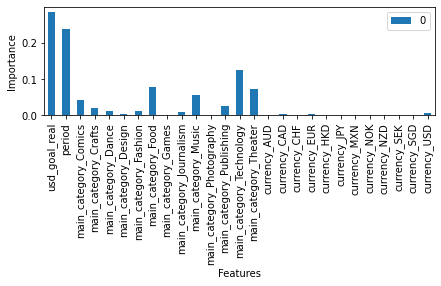

In [37]:
y_train = df['state'].values
X_train = df.drop('state', axis=1).values

# ランダムフォレストの設定
# n_estimator、決定木を10個つくる
# 過学習を防ぐため枝は増やしすぎない
# 総データ数の約1%である3,000をmin_samplesとする
#→importanceがすべて0となったので、100とする
clf = RandomForestClassifier(n_estimators=10, criterion="gini", max_depth=5, min_samples_split=100, min_samples_leaf=100, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df.columns[1:]).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [38]:
for i, est in enumerate(clf.estimators_):
    print(i)
    
    # 決定木の描画
    dot_data = StringIO() #dotファイル情報の格納先
    export_graphviz(est, out_file=dot_data,
                         feature_names=df.columns[1:],
                         class_names=['True', 'False'],
                         filled=True, rounded=True,
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))
    graph.write_pdf('tree.pdf'.format(i))

0


InvocationException: GraphViz's executables not found

→何を試しても上記エラーが消えないため断念。graphvizはインストールしたのだが...

## ⑤アダブーストと決定木

score= 0.6590909785255362
[0.33599103 0.24773152 0.03250335 0.02491736 0.023354   0.01332676
 0.04327613 0.04290792 0.01490228 0.02200897 0.02219118 0.01140227
 0.0174536  0.03501858 0.01204928 0.01109171 0.00628254 0.
 0.02212193 0.00679248 0.         0.00758913 0.00482731 0.
 0.         0.         0.04226067]


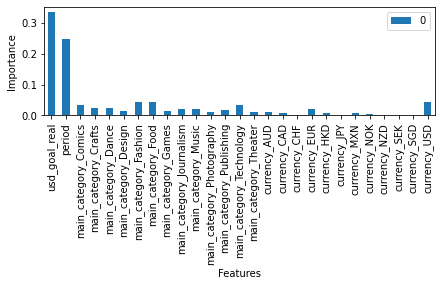

In [39]:
y_train = df['state'].values
X_train = df.drop('state', axis=1).values

# アダブーストの設定
# n_estimator、決定木を10個つくる
# 過学習を防ぐため枝は増やしすぎない
# 総データ数の約1%である3,000をmin_samplesとする
#→importanceがすべて0となったので、100とする
clf = AdaBoostClassifier(DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_split=100, min_samples_leaf=100), n_estimators=10, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df.columns[1:]).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [40]:
for i, est in enumerate(clf.estimators_):
    print(i)
    
    # 決定木の描画
    dot_data = StringIO() #dotファイル情報の格納先
    export_graphviz(est, out_file=dot_data,
                         feature_names=df.columns[1:],
                         class_names=['True', 'False'],
                         filled=True, rounded=True,
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))
    graph.write_pdf('tree.pdf'.format(i))

0


InvocationException: GraphViz's executables not found

→同様にエラーとなってしまう。なお、アダブーストの方が多少スコアが良い。

## ⑥ニューラルネットワーク

In [41]:
y = df['state'].values
X = df.drop('state', axis=1).values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327319 entries, 0 to 378660
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   state                      327319 non-null  int64  
 1   usd_goal_real              327319 non-null  float64
 2   period                     327319 non-null  int64  
 3   main_category_Comics       327319 non-null  uint8  
 4   main_category_Crafts       327319 non-null  uint8  
 5   main_category_Dance        327319 non-null  uint8  
 6   main_category_Design       327319 non-null  uint8  
 7   main_category_Fashion      327319 non-null  uint8  
 8   main_category_Food         327319 non-null  uint8  
 9   main_category_Games        327319 non-null  uint8  
 10  main_category_Journalism   327319 non-null  uint8  
 11  main_category_Music        327319 non-null  uint8  
 12  main_category_Photography  327319 non-null  uint8  
 13  main_category_Publishing   32

In [42]:
# データの準備 #3割をテストデータとする
y = df['state'].values
X = df.drop('state', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [43]:
# ニューラルネットワークの構築
model = Sequential()

# 1層目 # df.info()よりカラム数は27
model.add(Dense(14, activation='relu', input_dim=27))
# 2層目
model.add(Dense(6, activation='relu', input_dim=14))
# 3層目
model.add(Dense(3, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------
# SGDは最急降下法に相当する手法
# 他は最急降下法に加え他の工夫を加えたもの

# compile（モデルを完成させる）
model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

In [44]:
# 学習
# epochs・・学習を何順するか
# batch_size・・・一度にいくつのデータを使い学習するか
fit=model.fit(X_train,y_train,epochs=10,batch_size=20,validation_data=(X_test, y_test))

Epoch 1/10
11457/11457 [==============================] - 15s 1ms/step - loss: 188782.5351 - accuracy: 0.5887 - val_loss: 0.6779 - val_accuracy: 0.5926
Epoch 2/10
11457/11457 [==============================] - 14s 1ms/step - loss: 0.6777 - accuracy: 0.5907 - val_loss: 0.6762 - val_accuracy: 0.5926
Epoch 3/10
11457/11457 [==============================] - 15s 1ms/step - loss: 0.6773 - accuracy: 0.5912 - val_loss: 0.6761 - val_accuracy: 0.5926
Epoch 4/10
11457/11457 [==============================] - 14s 1ms/step - loss: 0.6769 - accuracy: 0.5919 - val_loss: 0.6761 - val_accuracy: 0.5926
Epoch 5/10
11457/11457 [==============================] - 14s 1ms/step - loss: 0.6774 - accuracy: 0.5904 - val_loss: 0.6760 - val_accuracy: 0.5926
Epoch 6/10
11457/11457 [==============================] - 14s 1ms/step - loss: 0.6773 - accuracy: 0.5909 - val_loss: 0.6760 - val_accuracy: 0.5926
Epoch 7/10
11457/11457 [==============================] - 15s 1ms/step - loss: 0.6773 - accuracy: 0.5907 - val_lo

【質問】  
データは約30万個あるので、epoch=10,batch_size=20では、最大でも200個のデータに対してしか学習できないということになりますか？  

In [47]:
# 各epochにおける損失と精度をデータフレームに格納
df_NN = pd.DataFrame(fit.history)

# 格納できているか確認
df_NN.head()

,loss,accuracy,val_loss,val_accuracy
0,43681.105469,0.590770,0.677866,0.59256
1,0.677501,0.590918,0.676211,0.59256
2,0.677344,0.590918,0.676116,0.59256
3,0.677308,0.590918,0.676100,0.59256
4,0.677193,0.590918,0.676039,0.59256


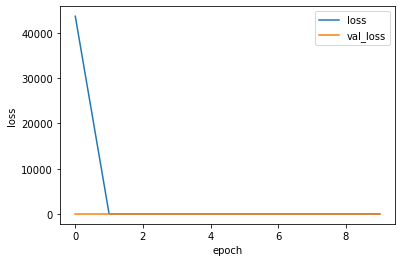

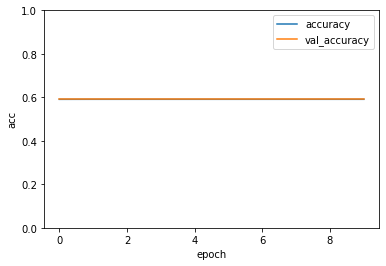

In [48]:
# グラフ化
df_NN[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df_NN[["accuracy", "val_accuracy"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

→グラフがおかしいのでパラメーターの設定がおかしい？  
    →とりあえずaccuracyを算出してみる

In [49]:
# 未知のデータを識別する
y_test_est = np.argmax(model.predict(X_test), axis=1)

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_test_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_est)

# カテゴリ「state」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率 = 59.256%
適合率（Precision） = 0.000%
再現率（Recall） = 0.000%
F1値（F1-score） = 0.000%


C:\Users\kjhsm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


→やはりおかしいが、原因が追究できなかったので、このまま提出とする

## 検討結果まとめ

**①ホールドアウト法（やり直し）**  
・正答率（Accuracy） = 63.835%  
・適合率（Precision） = 56.889%  
・再現率（Recall） = 45.707%  
・F1値（F1-score） = 50.688%  

**②交差検証法（やり直し）**  
・正答率（Accuracy） = 64.036%  
・適合率（Precision） = 58.326%  
・再現率（Recall） = 42.818%  
・F1値（F1-score） = 49.071%  

**③SVM（追加）**  
・正答率（Accuracy） = 62.050%  
・適合率（Precision） = 55.882%  
・再現率（Recall） = 36.938%  
・F1値（F1-score） = 44.477%  

**④ランダムフォレスト（追加）**  
・エラー

**⑤アダブースト&決定木（追加）**  
・エラー

**⑥ニューラルネットワーク（追加）**  
・正答率 = 59.256%  
・適合率（Precision） = 0.000%  
・再現率（Recall） = 0.000%  
・F1値（F1-score） = 0.000%  


Day1時の  
・正答率 = 61.257%  
・適合率（Precision） = 61.683%  
・再現率（Recall） = 92.413%  
・F1値（F1-score） = 73.984%  
よりは精度が向上している。 

## 課題
・SVMがグリッドサーチ後精度が少し下がった理由がわからない  
・ランダムフォレストとアダブーストのエラーが改善できない  
・ニューラルネットワークでの結果がおかしい  